<a href="https://colab.research.google.com/github/NavneetSajwan/Hindi-Vowel-Consonant-Classification/blob/master/Hindi_Vowel_Consonant_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image, ImageEnhance
import numpy as np
from time import time
import warnings
# warnings.filterwarnings("ignore")

In [0]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F

In [0]:
from torchvision import models

# Data Fetching

In [14]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [15]:
os.environ['KAGGLE_USERNAME'] = "navneetsajwan" 
os.environ['KAGGLE_KEY'] = "fc19a2773ae7ed2042f95e40250fa407" 
!kaggle competitions download -c padhai-hindi-vowel-consonant-classification
!unzip -q test.zip
!unzip -q train.zip

  0% 0.00/145k [00:00<?, ?B/s]
100% 145k/145k [00:00<00:00, 56.3MB/s]
 90% 82.0M/91.3M [00:00<00:00, 79.9MB/s]
100% 91.3M/91.3M [00:00<00:00, 117MB/s] 
 99% 90.0M/91.3M [00:00<00:00, 85.1MB/s]
100% 91.3M/91.3M [00:00<00:00, 104MB/s] 


In [0]:
files=os.listdir('train/')

In [17]:
len(files)

10000

In [18]:
fileX=sorted(files)
fileX[0]

'V0_C0_1.png'

In [19]:
vowel=int(files[0][1])
type(vowel)
# print(vowel)


int

In [0]:
y_vowel=[]
y_consonant=[]
for file in files:
  vowel_idx=int(file[1])
  cons_idx=int(file[4])
  y_vowel.append(vowel_idx)
  y_consonant.append(cons_idx)

In [21]:
print(min(y_vowel),max(y_vowel))
print(min(y_consonant),max(y_consonant))


0 9
0 9


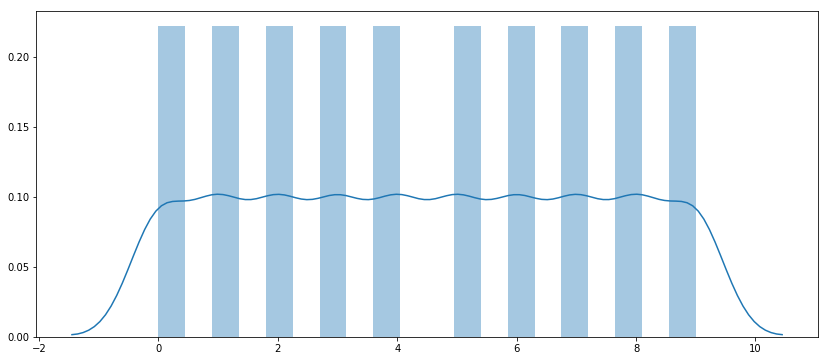

In [22]:
plt.figure(figsize=(14,6))
sns.distplot(y_vowel)

In [0]:
import pandas as pd
df= pd.read_csv("/content/drive/My Drive/vowel-consonant-mapping - Hindi.csv")

In [24]:
df.head(12)

,Unnamed: 0,Unnamed: 1,V0,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11
0,NaN,NaN,0,आ,इ,ई,उ,ऊ,ऋ,ए,ऐ,ऑ,ओ,औ
1,C0,0,अ,आ,इ,ई,उ,ऊ,ऋ,ए,ऐ,ऑ,ओ,औ
2,C1,क,क,का,कि,की,कु,कू,कृ,के,कै,कॉ,को,कौ
3,C2,ख,ख,खा,खि,खी,खु,खू,खृ,खे,खै,खॉ,खो,खौ
4,C3,ग,ग,गा,गि,गी,गु,गू,गृ,गे,गै,गॉ,गो,गौ
5,C4,घ,घ,घा,घि,घी,घु,घू,घृ,घे,घै,घॉ,घो,घौ
6,C5,ङ,ङ,ङा,ङि,ङी,ङु,ङू,ङृ,ङे,ङै,ङॉ,ङो,ङौ
7,C6,च,च,चा,चि,ची,चु,चू,चृ,चे,चै,चॉ,चो,चौ
8,C7,छ,छ,छा,छि,छी,छु,छू,छृ,छे,छै,छॉ,छो,छौ
9,C8,ज,ज,जा,जि,जी,जु,जू,जृ,जे,जै,जॉ,जो,जौ


In [0]:
vowels=list(df.iloc[1,2:12])
consonants= list(df.iloc[1:11,1])

In [26]:
len(consonants)

10

## Converting image into arrays



In [0]:
transformer = transforms.Compose([
                                  # transforms.Grayscale(1),
                                  transforms.ToTensor(),
                                  transforms.Normalize((0.5,),(0.5,))
                                ])

In [0]:
# image, vow, cons=trainset.__getitem__(3)
# print(image)

In [0]:
class DatasetHindi(Dataset):
  def __init__(self, folderpath, images_list, l_vowel=None, l_cons=None, train=True, transform=None ):
    self.folder_path=folderpath
    self.images_list =  images_list
    self.l_vowel = l_vowel
    self.l_cons = l_cons
    self.transform= transform

  def __len__(self):
    return len(self.images_list)

  def __getitem__(self, index):
    filepath= os.path.join(self.folder_path, self.images_list[index])
    image = Image.open(filepath).convert('RGB')
    image= ImageEnhance.Sharpness(image).enhance(3.0)
    # image= transforms.functional.adjust_brightness(image,2)
    # image = transforms.functional.adjust_contrast(image, 2)
    # image = transforms.functional.adjust_saturation(image,2)
    
    # torchvision.transforms.functional.to_tensor(image)
    # image = np.array(image).astype(np.uint8)
    # if image.shape[2]==4:
    #   image = image[:,:,:-1]
    # Reshaping the image to torchvision tensors
    # image = np.transpose(image, (2,0,1))
    # print(image.shape)
    if self.transform is not None:
      # print(image.shape)
      image = self.transform(image)
      # print(image.shape)
    if self.l_vowel is not None:
      l_v = self.l_vowel[index]

    if self.l_cons is not None:
      l_c = self.l_cons[index]

    return image, l_v, l_c

In [124]:
trainset = DatasetHindi('train/', files, y_vowel, y_consonant, transform=transformer)
batch=256
trainloader=DataLoader(trainset, batch_size= batch, shuffle= False)
image, lab_vowel, lab_cons= iter(trainloader).next()
image.shape
# print(lab_vowel)
# displaying the image post transforms


torch.Size([256, 3, 64, 64])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 0, 'झ आ')

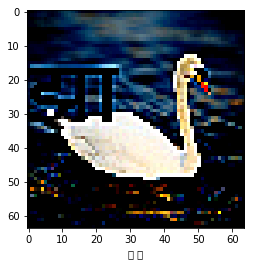

In [125]:
npimg=np.array(image)
npimg= np.transpose(npimg, (0,2,3,1))
sample = np.random.randint(batch)
sample=0
#Transformed Image
plt.figure()
plt.imshow(npimg[sample,:,:,:])
plt.xlabel(str(consonants[lab_cons[sample]])+" "+str(vowels[lab_vowel[sample]]))

# Creating the Network Class

In [32]:
device="cuda:0" if torch.cuda.is_available() else "cpu"
type(device)

str

In [0]:
resnet=models.resnet18(pretrained=True)

In [0]:
# def freeze_model(model):
#   for param in model.parameters():
#     param.requires_grad=False
final_in_features= resnet.fc.in_features
resnet.fc=nn.Linear(final_in_features, out_features=512 , bias=True)
# for param in model.parameters():
#   if param.requires_grad== True:
#     print(param.shape)

In [0]:
# freeze_model(model)

In [0]:
# Adding extra linear at fc for classifying consonant
# mod_fc= nn.Sequential(*(list(model.children())[-1],nn.Linear(512, 10, bias=True)))
# mod_fc.extend([nn.Linear(512, 10, bias=True)])
# new_model = nn.Sequential(*list(model.children())[:-1])

In [0]:
#modifying the last layer
# final_in_features = model.fc.in_features
# model.fc = nn.Linear(final_in_features, 512 ,bias =True)

In [0]:
class super_resnet(nn.Module):
  def __init__(self, model):
    super(super_resnet, self).__init__()
    self.net= model
    self.linear_vowel= nn.Sequential(nn.Linear(512,256), nn.ReLU(), nn.Linear(256, 10))
    self.linear_cons= nn.Sequential(nn.Linear(512,256), nn.ReLU(), nn.Linear(256, 10))
    self.softmax = nn.Softmax(dim=1)

  def forward(self, x):
    # print(x.shape)
    x=self.net(x)
    # print(x.shape)
    x_vowel = self.linear_vowel(x)
    # print(x_vowel.shape)
    x_vowel = self.softmax(x_vowel)
    x_cons = self.linear_cons(x)
    x_cons = self.softmax(x_cons)
    return x_vowel, x_cons

# Creating the Evaluation function

In [0]:
def evaluation(dataloader, model):
    total, correct_v, correct_c= 0, 0, 0
    for data in dataloader:
        inputs, lab_v, lab_c= data
        inputs, lab_v, lab_c= inputs.to(device), lab_v.to(device), lab_c.to(device)
        outputs_v, outputs_c = model(inputs.double())
        # print(outputs_v.shape)
        _, pred_v =torch.max(outputs_v, 1)
        # print(pred_v, lab_v)
        _, pred_c =torch.max(outputs_c, 1)
        total+= lab_v.size(0)
        correct_v+= (pred_v==lab_v).sum().item()
        correct_c+= (pred_c==lab_c).sum().item()
    return pred_v, pred_c, 100* correct_v/total, 100* correct_c/total


## Creating the Network Object

In [0]:
model = super_resnet(resnet).double().to(device)
for param in model.parameters():
    nn.init.xavier_uniform_(param.unsqueeze(dim=1))
    param.squeeze()
loss_fn=nn.CrossEntropyLoss()


In [0]:
opt=optim.Adam(model.parameters(), lr=0.001 )

## Loading into dataloaders

In [0]:
import copy
from tqdm import tqdm_notebook

In [0]:
batch= 32
trainloader = DataLoader(trainset, batch_size=batch, shuffle=False, num_workers=1)
# evalloader= DataLoader(evalset, batch_size=batch_size, shuffle=False)
# testloader= DataLoader(testset, batch_size=X_test.shape[0],shuffle=False)

# Training the Network

tensor(4.6061, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)


tensor(4.6212, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)


tensor(4.5274, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)


tensor(4.5552, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)


tensor(4.4758, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)


tensor(4.4659, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)


tensor(4.5897, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)


tensor(4.4061, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)


tensor(4.4981, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)


tensor(4.3074, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
Training time: 492.4944269657135


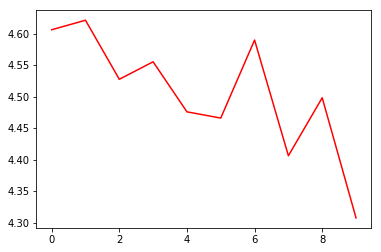

Loss:
Training vowel Accuracy: 50.88 consonant accuracy: 18.16


In [130]:
# using two faced fc
tic=time()
model.train()
loss_per_epoch=[]
loss_arr=[]
max_epochs= 10
min_loss=1000
n_iters=np.ceil(10000/batch)
for epoch in tqdm_notebook(range(max_epochs),total=max_epochs,unit='epochs'):
    for data in tqdm_notebook(trainloader,total=len(trainloader),unit='batch'):
        inputs, lab_v, lab_c = data
        inputs, lab_v, lab_c = inputs.to(device), lab_v.to(device), lab_c.to(device)
        opt.zero_grad()
        # print(inputs.shape)
        outputs_v, outputs_c = model(inputs.double())
        loss=loss_fn(outputs_v, lab_v) + loss_fn(outputs_c, lab_c)
        loss.backward()
        opt.step()
        # loss_arr.append(loss.item())
        # if min_loss>loss.item():
        #     min_loss=loss.item()
        #     best_model=copy.deepcopy(model.state_dict())
        # if i % 8==0:
        #     print("Epoch: %d Iteration: %d/%d Loss: %0.3f" %(epoch, i, n_iters, loss.item()))
        del inputs, lab_v, lab_c, outputs_v, outputs_c
        # torch.cuda.empty_cache()
    print(loss)
    loss_per_epoch.append(loss.item())
toc=time()
print("Training time:", toc-tic)
plt.plot(loss_per_epoch, 'r')
plt.show()
model.eval()
# torch.save(best_model,"../input/checkpoint/best_model.pth")
# model.load_state_dict(best_model)
# with torch.no_grad():
_, _, acc_v, acc_c= evaluation(trainloader, model)
print("Loss:")
print("Training vowel Accuracy: %0.2f consonant accuracy: %0.2f" %( acc_v , acc_c ))
# print("Test Accuracy: %0.2f" %(evaluation(evalloader,model)))

In [0]:
from sklearn.metrics import confusion_matrix
# batch= 512
trainloader = DataLoader(trainset, batch_size=, shuffle=False, num_workers=0)
model.eval()
with torch.no_grad():
  pred_v, pred_c,_, _ = evaluation(trainloader, model)
cm= confusion_matrix(pred_v.cpu(), y_vowel[-1000:])
print(cm)

In [0]:
cm= confusion_matrix(pred_c.cpu(), y_consonant[-1000:])
print(cm)

In [0]:
plt.figure(figsize= (14,6))
plt.plot(loss_arr)

In [0]:
outputs_v

In [0]:
outputs_v

In [108]:
_,scat=torch.max(outputs_v,1)
scat

tensor([0.1752, 0.1757, 0.1752, 0.1753, 0.1755, 0.1752], device='cuda:0',
       dtype=torch.float64, grad_fn=<MaxBackward0>)